In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

aviation_file = "NTSBAviationData.csv"
df = pd.read_csv(aviation_file, encoding="latin1")
df.head()

/var/folders/7l/h7qnw85j2hlf4tgr241lw5f00000gn/T/ipykernel_60516/997574546.py:5: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(aviation_file, encoding="latin1")


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [2]:
date_cols = ["Event.Date", "Publication.Date"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col],errors="coerce")

categorical_cols = [
    "Investigation.Type", "Injury.Severity", "Aircraft.damage",
    "Aircraft.Category", "Amateur.Built", "Engine.Type",
    "FAR.Description", "Schedule", "Purpose.of.flight",
    "Weather.Condition", "Broad.phase.of.flight", "Report.Status"
]
for col in categorical_cols:
    df[col] = df[col].astype("category")

/var/folders/7l/h7qnw85j2hlf4tgr241lw5f00000gn/T/ipykernel_60516/3811385984.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col],errors="coerce")


In [3]:
def line_chart(df, date_col, group_col, years=None, title=None):
    """plots counts per year for categories in group_col for 
    given num of years"""
    df = df.copy()
    
    # restrict to last n years 
    if years is not None:
        max_year = df[date_col].dt.year.max()
        # include all 20 years 
        cutoff = max_year - (years)
        df = df[df[date_col].dt.year >= cutoff]

    # extract year
    df["Year"] = df[date_col].dt.year

    # group by year + category
    counts = (
        df.groupby(["Year", group_col])
        .size()
        .reset_index(name="Count")
        .pivot(index="Year", columns=group_col, values="Count")
    )

    # plotting
    ax = counts.plot(kind="line", marker="o")
    if not title:
        title = f"{group_col} counts"
        if years:
            title += f" (last {years} years)"
    # ticls for every 2 years 
    ax.set_xticks(counts.index[::2])
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.set_xlabel("Year")
    ax.legend(title=group_col)
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.show()

/var/folders/7l/h7qnw85j2hlf4tgr241lw5f00000gn/T/ipykernel_60516/2658980040.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Year", group_col])


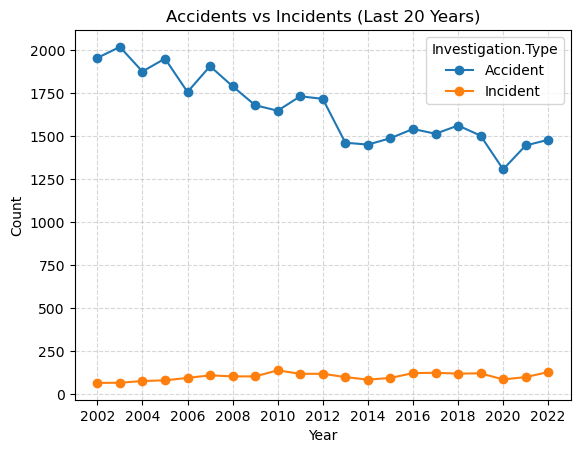

In [4]:
# line chart
line_chart(df, "Event.Date", "Investigation.Type", years=20,
           title="Accidents vs Incidents (Last 20 Years)")

The line chart shows accidents vs. incidents over the last 20 years. Incidents happen less than accidents, though it seems like incidents are gradually increasing over time while accidents are decreasing at a faster rate. So, it seems like aviation is getting safer in terms of accidents, while incidents are more visible due to increased reporting.

In [5]:
print(df.isna().sum())

Event.Id                      0
Investigation.Type            0
Accident.Number               0
Event.Date                    0
Location                     52
Country                     226
Latitude                  54507
Longitude                 54516
Airport.Code              38757
Airport.Name              36185
Injury.Severity            1000
Aircraft.damage            3194
Aircraft.Category         56602
Registration.Number        1382
Make                         63
Model                        92
Amateur.Built               102
Number.of.Engines          6084
Engine.Type                7096
FAR.Description           56866
Schedule                  76307
Purpose.of.flight          6192
Air.carrier               72241
Total.Fatal.Injuries      11401
Total.Serious.Injuries    12510
Total.Minor.Injuries      11933
Total.Uninjured            5912
Weather.Condition          4492
Broad.phase.of.flight     27165
Report.Status              6384
Publication.Date          13771
dtype: i

In [6]:
# dropping na and filling na with 0 show very different thigns, why is that?
df["Year"] = df["Event.Date"].dt.year

event_counts = df.groupby("Year").agg(
    total_events = ("Event.Id", "count"),
    fatal_known  = ("Total.Fatal.Injuries", lambda x: x.notna().sum()),
    fatal_na     = ("Total.Fatal.Injuries", lambda x: x.isna().sum())
).reset_index()

print(event_counts)

    Year  total_events  fatal_known  fatal_na
0   1948             1            1         0
1   1962             1            1         0
2   1974             1            1         0
3   1977             1            1         0
4   1979             2            1         1
5   1981             1            1         0
6   1982          3593         3569        24
7   1983          3556         3545        11
8   1984          3457         3441        16
9   1985          3096         3085        11
10  1986          2880         2873         7
11  1987          2828         2816        12
12  1988          2730         2710        20
13  1989          2544         2535         9
14  1990          2518         2503        15
15  1991          2462         2441        21
16  1992          2355         2346         9
17  1993          2313         2306         7
18  1994          2257         2244        13
19  1995          2309         2298        11
20  1996          2187         217

In [7]:
# proportion chart 
def proportion_chart(df, date_col, group_col, title=None):
    """Makes a proportion chart of fatal vs non-fatal events over time"""
    # remove years before 1982, as only max 1/2 event was recorded 
    df = df[df["Event.Date"].dt.year >= 1982].copy()

    # some cleaning for all the na's: classify fatal vs non fatal- eveyrting w na was non fatal
    # make new col for this 
    df["FatalEvent"] = df[group_col].fillna(0).apply(lambda x: "Fatal" if x > 0 else "Non-Fatal")

    # group by year + group col
    df["Year"] = df[date_col].dt.year.astype(int)
    counts = (
        df.groupby(["Year", "FatalEvent"])
        .size()
        .reset_index(name="Count")
        .pivot(index="Year", columns="FatalEvent", values="Count")
    )

    # proportions
    proportions = counts.div(counts.sum(axis=1), axis=0)

    # plot as stacked area
    ax = proportions.plot(kind="area", stacked=True, alpha=0.6, figsize=(8,5))
    if not title:
        title = "Proportion of Fatal vs Non-Fatal Events"
    ax.set_title(title)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Year")
    plt.legend(title='Event Type', loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.show()

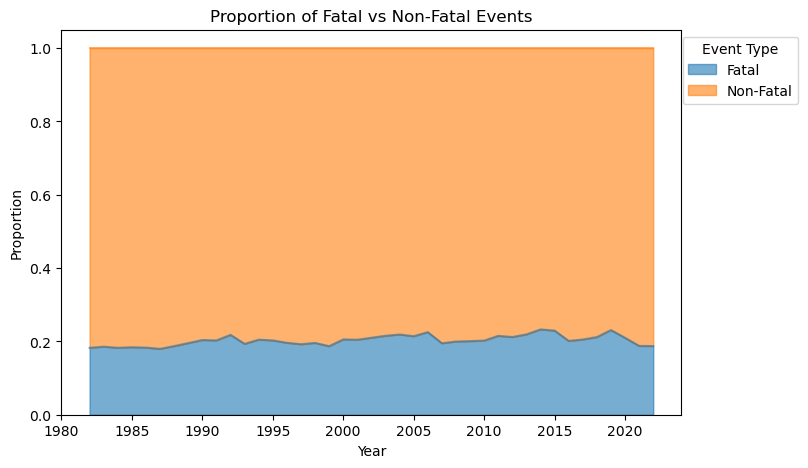

In [8]:
proportion_chart(df, "Event.Date", "Total.Fatal.Injuries",
                 title="Proportion of Fatal vs Non-Fatal Events")

This proportion chart shows that fatal events have been relatively constant over the years and account for about 20% of all reported events. There were several null values in for fatality counts, which were assumed to be 0 fatalities (so, a non-fatal event) and years before 1982 were removed, since only about 2 events per year were recorded and therefore misrepresented the proportions over time. Although the fatality proportion fluctuates slightly with noticeable spikes around 1993 and 2019, e.g., the overall trend has been stable. This consistency suggests that while the absolute number of accidents has declined, the relative share of fatal vs. non fatal outcomes has not shifted dramatically.

In [9]:
def safety_score(df, date_col, fatal_col, year):
    """compute safety score for the most recent year: cafety score = % of non fatal events"""
    df = df.copy()
    recent = df[df[date_col].dt.year == year]

    total_events = len(recent)
    non_fatal_events = (recent[fatal_col].fillna(0) == 0).sum()

    score = (non_fatal_events / total_events) * 100 if total_events > 0 else 0
    return year, score


The safety metric is defined here is determining all the non fatal counts per year in comparison to total events and using that proporition to represent the safety.

In [10]:
# most recent year in dataset
latest_year = df["Event.Date"].dt.year.max()
year, score = safety_score(df, "Event.Date", "Total.Fatal.Injuries",latest_year)
print(f"Safety Score for {year}: {score:.2f}")

Safety Score for 2022: 81.27


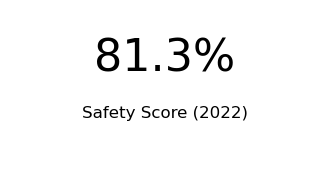

In [11]:
# card 
fig, ax = plt.subplots(figsize=(4,2))
ax.text(0.5, 0.6, f"{score:.1f}%", fontsize=32, ha="center")
ax.text(0.5, 0.3, f"Safety Score ({year})", fontsize=12, ha="center")
ax.axis("off")
plt.show()


Insight Goal:

Aviation safety has shown clear progress over the past four decades, though some areas remain stagnant. Since the early 2000s, the number of accidents has steadily declined from around 2,000 per year to about 1,400–1,500 in the 2020s, indicating significant improvements in accident prevention through better technology, training, and regulation. At the same time, the number of reported incidents less severe events has gradually increased. This rise is likely due to stronger monitoring and reporting practices rather than a real decline in safety, suggesting that the industry is catching more potential risks before they escalate into serious accidents.

When examining outcomes, however, the proportion of fatal versus non fatal events has remained relatively unchanged. Roughly 80% of events each year are non fatal, while about 20% result in fatalities, a ratio that has stayed consistent since the 1980s despite occasional spikes in years such as 1993 and 2019. This indicates that while the total number of accidents has decreased, the likelihood of a fatal outcome when an accident does occur has not improved substantially. The safety score, defined as the proportion of non fatal events out of total recorded events has typically ranged between 75% and 85% (can be seen in the proportion chart for the temporal chnages of the safety score) showing stability rather than upward progress in survivability outcomes.

Overall, the data demonstrates that aviation has become safer in terms of reducing the frequency of serious accidents, but survivability within accidents has not improved to the same degree. This points to progress in prevention, stagnation in fatality outcomes, and a need for continued attention to accident survivability measures such as emergency response, crashworthiness, and onboard safety systems. Additionally, some periods, particularly between 2001 and 2007, suffer from missing data, highlighting the importance of consistent reporting to ensure accurate long term safety evaluations.